In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T

import os
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from scipy.special import sph_harm
import matplotlib.cm

In [2]:
n_epoch = 200
batch_size = 16
lr = 1e-4
betas = (0.9, 0.999)

input_PATH = "../Data/Geoid/new_results_1k_zero/zero_1k-inv.npy"
output_PATH = "../Data/Geoid/new_results_1k_zero/zero_1k-geoid.npy"

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print("Current device is ",device)


# Fit the MinMaxScalar for output data
output_for_Scalar = np.load(output_PATH)
scaler = MinMaxScaler()
scaler.fit(output_for_Scalar)
print("Fit the output range to [0,1] using MinMaxscaler")


'''
# Fit another MinMaxScalar for input data
input_for_Scalar = np.load(input_PATH)
scaler_input = StandardScaler()
scaler_input.fit(input_for_Scalar)
print("Fit the input range to [0,1] using MinMaxscaler")
'''

# make results determinstic
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Current device is  cpu
Fit the output range to [0,1] using MinMaxscaler


In [3]:
class KMNIST(Dataset):
    
    def __init__(self, input_path, output_path):
        # Load the input and output
        input_data = np.load(input_path)
        output_data = scaler.transform(np.load(output_path))
        
        self.input = input_data
        self.output = output_data
        
    def __len__(self):
        return len(self.input)

    def __getitem__(self, index):
        input_item = self.input[index]
        output_item = self.output[index]
        
        return input_item, output_item

In [4]:
testingAndValidation_split = 0.2
validation_split = 0.1

# Load the input and output as a complete dataset

geoid_dataset = KMNIST(
    input_PATH,
    output_PATH,
)


# Creating data indices for training, testing and validation splits
# Reference: https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets
geoid_dataset_size = len(geoid_dataset)
geoid_indices = list(range(geoid_dataset_size))

geoid_training_testing_split = int(np.floor(testingAndValidation_split * geoid_dataset_size))
geoid_testing_validation_split = int(np.floor(validation_split * geoid_dataset_size))

np.random.shuffle(geoid_indices)
geoid_train_indices, geoid_val_indices ,geoid_test_indices = geoid_indices[geoid_training_testing_split:], geoid_indices[:geoid_testing_validation_split], geoid_indices[geoid_testing_validation_split:geoid_training_testing_split] 

# Creating data samplers
geoid_train_sampler = SubsetRandomSampler(geoid_train_indices)
geoid_test_sampler = SubsetRandomSampler(geoid_test_indices)
geoid_valid_sampler = SubsetRandomSampler(geoid_val_indices)

geoid_train_loader = DataLoader(
    dataset=geoid_dataset,
    batch_size = batch_size,
    sampler=geoid_train_sampler,
)

geoid_test_loader = DataLoader(
    dataset=geoid_dataset,
    batch_size = batch_size,
    sampler=geoid_test_sampler,
)

geoid_validation_loader = DataLoader(
    dataset=geoid_dataset,
    batch_size = batch_size,
    sampler=geoid_valid_sampler,
)

'''

generator = torch.Generator().manual_seed(42)
train_dataset, test_dataset, validation_dataset = random_split(geoid_dataset, [0.8,0.1,0.1], generator = generator)

geoid_train_loader = DataLoader(
    dataset=train_dataset,
    batch_size = batch_size,
    shuffle = True
)

geoid_test_loader = DataLoader(
    dataset=test_dataset,
    batch_size = batch_size,
    shuffle = False
)

geoid_validation_loader = DataLoader(
    dataset=validation_dataset,
    batch_size = batch_size,
    shuffle = False
)

'''

print("Training data, testing data and validation data is spilt into 8:1:1")

Training data, testing data and validation data is spilt into 8:1:1


In [5]:
'''
train_input, train_output = next(iter(geoid_train_loader))

print(f"Feature batch shape: {train_input.size()}")
print(f"Labels batch shape: {train_output.size()}")

test_index = 1
train_input_batch_sample = train_input[test_index]
train_output_batch_sample = train_output[test_index]

print(f"Input: {train_input_batch_sample}")
print(f"Output: {train_output_batch_sample}")
'''

'\ntrain_input, train_output = next(iter(geoid_train_loader))\n\nprint(f"Feature batch shape: {train_input.size()}")\nprint(f"Labels batch shape: {train_output.size()}")\n\ntest_index = 1\ntrain_input_batch_sample = train_input[test_index]\ntrain_output_batch_sample = train_output[test_index]\n\nprint(f"Input: {train_input_batch_sample}")\nprint(f"Output: {train_output_batch_sample}")\n'

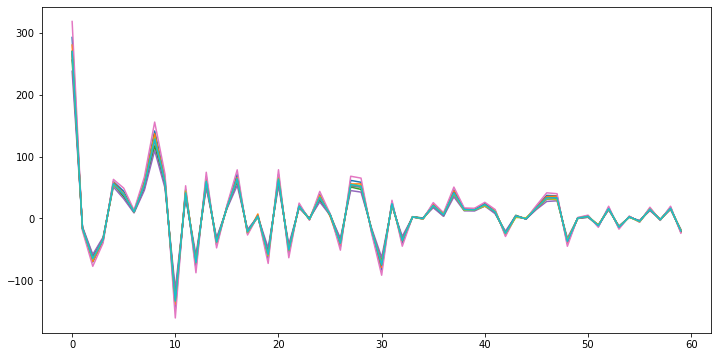

In [6]:
voutput = np.load(output_PATH)

nmodels, _ = voutput.shape

plt.figure(figsize=(12, 6))

# Just plot every 100th model output and output to observe the pattern
for i in range(1, nmodels, 100):

    plt.plot(voutput[i, :])

plt.show()

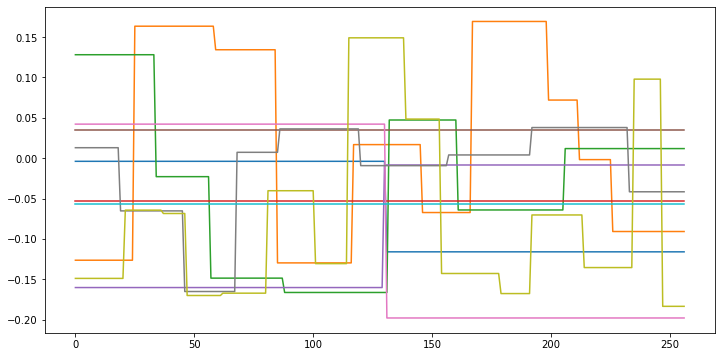

In [7]:
vinput = np.load(input_PATH)

nmodels, _ = vinput.shape

plt.figure(figsize=(12, 6))

# Just plot every 100th model input and output to observe the pattern
for i in range(1, nmodels, 100):

    plt.plot(vinput[i, :])

plt.show()

/Users/xuke/opt/anaconda3/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:387: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  return matplotlib.axes.Axes.draw(self, renderer=renderer,


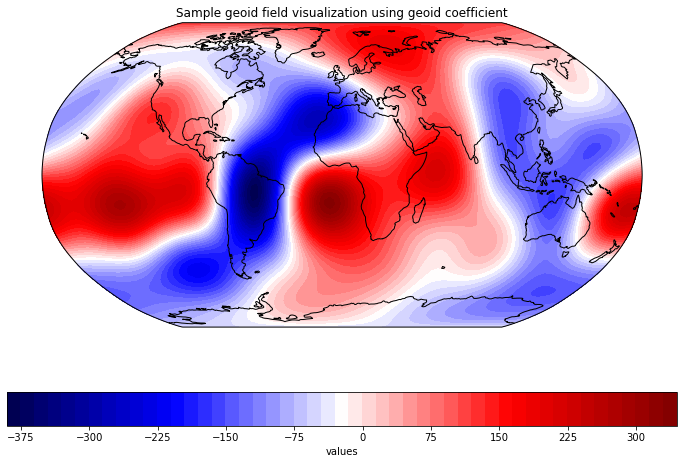

In [8]:
import cartopy.crs as ccrs

# Function to fix errors when using pyshtools
def patch_asscalar(a):
    return a.item()

setattr(np, "asscalar", patch_asscalar)

def patch_alen(a):
    return a.len()

setattr(np, "alen", patch_asscalar)


import pyshtools

def mk_image_pyshtools(coeff, phi, theta, latsamples = 100, lonsamples = 100):

    sph = pyshtools.SHCoeffs.from_zeros(lmax = 7, normalization = 'ortho')

    offset = 0
    for l in range(2, 8):
        for m in range(-l, l + 1):
            sph.set_coeffs(coeff[offset], l, m)
            offset += 1

    image = sph.expand(lon = theta.flatten() * 180.0/np.pi,
                       lat = 90.0 - phi.flatten() * 180.0/np.pi)

    return image.reshape(theta.shape)

# Pick a set of coefficients
phi = np.linspace(0.0, np.pi, 100)
theta = np.linspace(0.0, 2.0*np.pi, 100)
theta, phi = np.meshgrid(theta, phi)

# The Cartesian coordinates of the unit sphere
x = np.sin(phi) * np.cos(theta)
y = np.sin(phi) * np.sin(theta)
z = np.cos(phi)

lons = theta * 180.0/np.pi
lats = 90.0 - phi*180.0/np.pi

sample_geoid_image = mk_image_pyshtools(voutput[123, :], phi, theta)

plt.figure(figsize=(12, 8))

fig = plt.figure(1)
ax = fig.add_subplot(111, projection = ccrs.Robinson(central_longitude = 0.0))

sc = ax.contourf(lons, lats, sample_geoid_image, 50, transform = ccrs.PlateCarree(), cmap = 'seismic')
ax.coastlines()
fig.colorbar(sc, ax=ax, orientation="horizontal", label="values")
                                        
plt.title("Sample geoid field visualization using geoid coefficient")
plt.xlabel("Horizontal degree")
plt.ylabel("Vertical degree")
                                        
plt.show()

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()    
        self.fc1 = nn.Linear(257, 200)
        
        self.fc2 = nn.Linear(200, 160)
        self.fc3 = nn.Linear(160, 120)
        self.fc4 = nn.Linear(120, 80)
        
        self.fc5 = nn.Linear(80, 60)
        
        self.relu = nn.ReLU()
        self.drop = nn.Dropout()
    
    def forward(self, x):                              
        x = x.to(torch.float32)
        
        out = self.fc1(x)
        out = self.relu(out)
        
        out = self.fc2(out)
        out = self.relu(out)
        
        out = self.fc3(out)
        out = self.relu(out)
        
        out = self.fc4(out)
        out = self.relu(out)
        
        out = self.fc5(out)
        
        return out

In [9]:
def train(model, train_loader, val_loader, device, optimizer, n_epoch):
    
    criterion = nn.MSELoss()
    
    minimum_validation_loss = 10000000
    best_model_index = -1
    
    running_loss_list = []
    validation_loss_list = []

    # n_epoch times of iterations
    for epoch in range(n_epoch):

        running_loss = 0.0

        model.train()
        
        for data in train_loader:
            # get a batch of inputs and labels
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad(set_to_none=True)

            # Get output features, calculate loss and optimize
            outputs = model(inputs)
            loss = criterion(outputs.float(), labels.float())
            
            loss.backward()
            optimizer.step()

            # Add to the total training loss
            running_loss += loss.item()

        # print some statistics
        print(epoch+1,"epochs have finished")
        print("Current training loss is ",running_loss)
        running_loss_list.append(running_loss)
        running_loss = 0.0

        # Valiadation
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            valid_loss = 0.0
            for data in val_loader:
                inputs, labels = data[0].to(device), data[1].to(device)
                
                # Get output features and calculate loss
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # If the loss value is less than 0.01, we consider it being accurate
                for j in range(len(labels)):
                    single_loss = criterion(outputs[j], labels[j])
                    if single_loss.item() <= 0.01:
                        correct += 1
                    total += 1

                # Add to the validation loss
                valid_loss += loss.item()

            # Calculate valiadation accuracy and print Validation statistics
            print("Validation loss for this epoch is",valid_loss)
            print("Validation Accuracy for this epoch is", 100*correct//total)
            validation_loss_list.append(valid_loss)

        # Update the statistics for the best model
        if valid_loss <= minimum_validation_loss:
            minimum_validation_loss = valid_loss

            # Store the best models
        
            PATH = 'geoid_model_best.pth'

            torch.save(model.state_dict(), PATH)
            print("This model is now saved to Path:",PATH)
            
            best_model_index = epoch
            
        print()
    
    # Training finished, print the statistics for the best model
    print('Finished Training')
    print("Best model has a validation loss of ",minimum_validation_loss)
    print("Best model is in epoch ",best_model_index+1)
    
    # Plot the Training loss and validation loss during training
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(running_loss_list)
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss in each epoch')

    plt.subplot(2, 1, 2)
    plt.plot(validation_loss_list)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss in each epoch')
    
    plt.subplots_adjust(hspace=1)

    plt.show()

In [10]:
model = Net().to(device)
#optimizer = Minimizer(model.parameters(), method='bfgs', disp=2, max_iter = 2)
#optimizer = torch.optim.LBFGS(model.parameters(), lr=lr)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=betas)

1 epochs have finished
Current training loss is  13.75338263809681
Validation loss for this epoch is 1.8470967410096604
Validation Accuracy for this epoch is 0
This model is now saved to Path: geoid_model_best.pth

2 epochs have finished
Current training loss is  10.230443775653839
Validation loss for this epoch is 0.8970545254741031
Validation Accuracy for this epoch is 0
This model is now saved to Path: geoid_model_best.pth

3 epochs have finished
Current training loss is  4.236909236758947
Validation loss for this epoch is 0.3879688683544585
Validation Accuracy for this epoch is 1
This model is now saved to Path: geoid_model_best.pth

4 epochs have finished
Current training loss is  1.9177403021603823
Validation loss for this epoch is 0.22844518746034298
Validation Accuracy for this epoch is 13
This model is now saved to Path: geoid_model_best.pth

5 epochs have finished
Current training loss is  1.3324744887650013
Validation loss for this epoch is 0.18668402665524958
Validation Acc

40 epochs have finished
Current training loss is  0.012833694418077357
Validation loss for this epoch is 0.002518147011340479
Validation Accuracy for this epoch is 100

41 epochs have finished
Current training loss is  0.012272821804799605
Validation loss for this epoch is 0.0030933500136738146
Validation Accuracy for this epoch is 100

42 epochs have finished
Current training loss is  0.011650374843156897
Validation loss for this epoch is 0.002325202434696969
Validation Accuracy for this epoch is 100
This model is now saved to Path: geoid_model_best.pth

43 epochs have finished
Current training loss is  0.011097993894509273
Validation loss for this epoch is 0.002248626941123014
Validation Accuracy for this epoch is 100
This model is now saved to Path: geoid_model_best.pth

44 epochs have finished
Current training loss is  0.010433693962113466
Validation loss for this epoch is 0.0021759564213432005
Validation Accuracy for this epoch is 100
This model is now saved to Path: geoid_model_b

82 epochs have finished
Current training loss is  0.0035226510426582536
Validation loss for this epoch is 0.0011235773343263955
Validation Accuracy for this epoch is 100

83 epochs have finished
Current training loss is  0.003464415203779936
Validation loss for this epoch is 0.0011915193502397279
Validation Accuracy for this epoch is 100

84 epochs have finished
Current training loss is  0.003332483081976534
Validation loss for this epoch is 0.0011002431712718171
Validation Accuracy for this epoch is 100
This model is now saved to Path: geoid_model_best.pth

85 epochs have finished
Current training loss is  0.003365109791047871
Validation loss for this epoch is 0.001076470185335728
Validation Accuracy for this epoch is 100
This model is now saved to Path: geoid_model_best.pth

86 epochs have finished
Current training loss is  0.0032710802988731302
Validation loss for this epoch is 0.0012259871978665797
Validation Accuracy for this epoch is 100

87 epochs have finished
Current training 

128 epochs have finished
Current training loss is  0.001821274292524322
Validation loss for this epoch is 0.0008331293162808867
Validation Accuracy for this epoch is 100

129 epochs have finished
Current training loss is  0.0018807801443472272
Validation loss for this epoch is 0.0009118581090620346
Validation Accuracy for this epoch is 100

130 epochs have finished
Current training loss is  0.0018178206264565233
Validation loss for this epoch is 0.0009424069870530336
Validation Accuracy for this epoch is 100

131 epochs have finished
Current training loss is  0.0018379862085566856
Validation loss for this epoch is 0.00079414866817286
Validation Accuracy for this epoch is 100
This model is now saved to Path: geoid_model_best.pth

132 epochs have finished
Current training loss is  0.0017231697411261848
Validation loss for this epoch is 0.0008744217038447246
Validation Accuracy for this epoch is 100

133 epochs have finished
Current training loss is  0.0017866610432974994
Validation loss 

173 epochs have finished
Current training loss is  0.0008436467642241041
Validation loss for this epoch is 0.0007018922595917709
Validation Accuracy for this epoch is 100
This model is now saved to Path: geoid_model_best.pth

174 epochs have finished
Current training loss is  0.0008058939797592757
Validation loss for this epoch is 0.0008295571540420082
Validation Accuracy for this epoch is 100

175 epochs have finished
Current training loss is  0.0008138519274325517
Validation loss for this epoch is 0.000676166054651617
Validation Accuracy for this epoch is 100
This model is now saved to Path: geoid_model_best.pth

176 epochs have finished
Current training loss is  0.0008188372858057846
Validation loss for this epoch is 0.0007270522886445704
Validation Accuracy for this epoch is 100

177 epochs have finished
Current training loss is  0.0007389581746792828
Validation loss for this epoch is 0.0006776075957953488
Validation Accuracy for this epoch is 100

178 epochs have finished
Current 

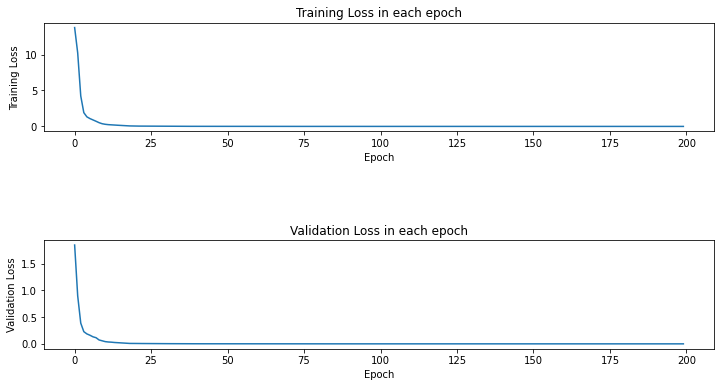

'\ncriterion = nn.MSELoss()\n\ndef closure():\n    for data in geoid_train_loader:\n        # get a batch of inputs and labels\n        inputs, labels = data[0].to(device), data[1].to(device)\n        \n    optimizer.zero_grad()\n    output = model(inputs)\n    loss = criterion(output.float(), labels.float())\n    \n    return loss\n\nloss = optimizer.step(closure)\nprint(loss.item())\n'

In [11]:
train(model, geoid_train_loader, geoid_validation_loader, device, optimizer, n_epoch)
'''
criterion = nn.MSELoss()

def closure():
    for data in geoid_train_loader:
        # get a batch of inputs and labels
        inputs, labels = data[0].to(device), data[1].to(device)
        
    optimizer.zero_grad()
    output = model(inputs)
    loss = criterion(output.float(), labels.float())
    
    return loss

loss = optimizer.step(closure)
print(loss.item())
'''

In [12]:
def test(model, test_loader, device):

    # Load the model from the input model_path  
    #model.load_state_dict(torch.load(model_path))

    correct = 0
    total = 0
    criterion = nn.MSELoss()
    total_loss = 0.0
    
    best_worst_error_list = [1000000, 0]
    best_worst_input_list = [0, 0]
    best_worst_output_list = [0, 0]
    best_worst_predicted_list = [0, 0]
    
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
                
            # Get output features and calculate loss
            outputs = model(inputs)
            loss = criterion(outputs, labels)
                
            # If the loss value is less than 0.01, we consider it being accurate
            for j in range(len(labels)):
                single_loss = criterion(outputs[j], labels[j])
                if single_loss.item() <= 0.01:
                    correct += 1
                total += 1
                
                # Record worst error
                if single_loss.item() > best_worst_error_list[1]:
                    best_worst_error_list[1] = single_loss.item()
                    best_worst_input_list[1] = inputs[j]
                    best_worst_output_list[1] = labels[j]
                    best_worst_predicted_list[1] = outputs[j]
                    
                # Record best error
                if single_loss.item() < best_worst_error_list[0]:
                    best_worst_error_list[0] = single_loss.item()
                    best_worst_input_list[0] = inputs[j]
                    best_worst_output_list[0] = labels[j]
                    best_worst_predicted_list[0] = outputs[j]
                    

            # Add to the validation loss
            total_loss += loss.item()

    # Calculate the overall accuracy and return the accuracy and test loss
    print("Total loss for the model is",total_loss)
    print("Accuracy for the model is", 100*correct//total)
    print()
    
    # Draw some plots for the best and the worst error
    print("Best model has a error of ", best_worst_error_list[0])
    
    plt.figure(figsize=(12, 6))
    
    plt.title("Best case input")
    plt.plot(best_worst_input_list[0].detach().numpy())

    plt.show()
    
    
    plt.figure(figsize=(12, 6))
    
    plt.title("Best case plot")
    plt.plot(scaler.inverse_transform([best_worst_output_list[0].detach().numpy()])[0], label='Data Output')
    plt.plot(scaler.inverse_transform([best_worst_predicted_list[0].detach().numpy()])[0], label='Predicted Output')
    plt.legend()

    plt.show()
    
    
    print("Worst model has a error of ", best_worst_error_list[1])
    
    plt.figure(figsize=(12, 6))
    
    plt.title("Worst case input")
    plt.plot(best_worst_input_list[1].detach().numpy())

    plt.show()
    
    plt.figure(figsize=(12, 6))
    
    plt.title("Worst case plot")
    plt.plot(scaler.inverse_transform([best_worst_output_list[1].detach().numpy()])[0], label='Data Output')
    plt.plot(scaler.inverse_transform([best_worst_predicted_list[1].detach().numpy()])[0], label='Predicted Output')
    plt.legend()

    plt.show()
    
    #return 100*correct//total, total_loss

Total loss for the model is 0.0006523649456915537
Accuracy for the model is 100

Best model has a error of  7.804676050842155e-07


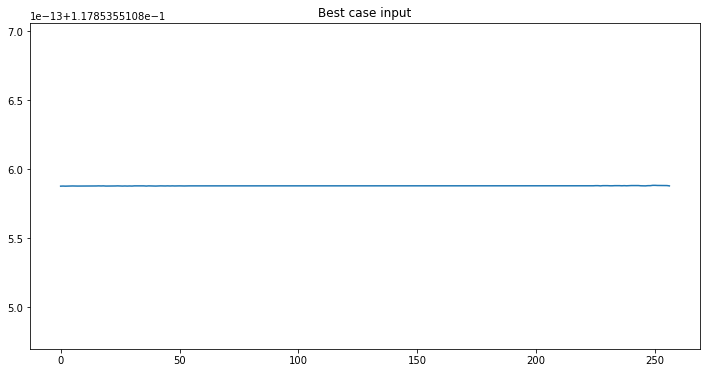

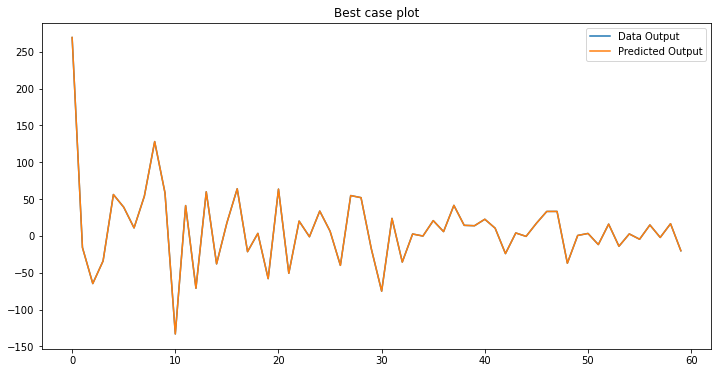

Worst model has a error of  9.761356123353227e-05


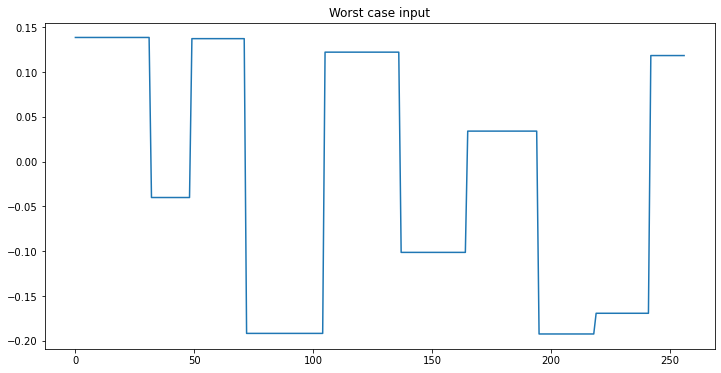

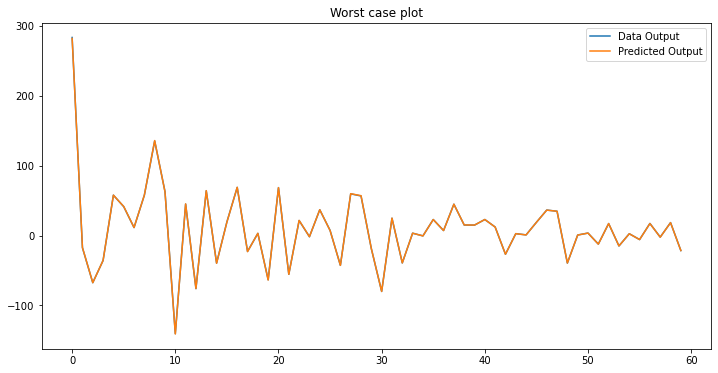

In [13]:
# Print Accuracy for the training data using the current model (Not the best one)
test(model, geoid_train_loader, device)

Total loss for the model is 0.0005452869412227539
Accuracy for the model is 100

Best model has a error of  7.807725056434319e-07


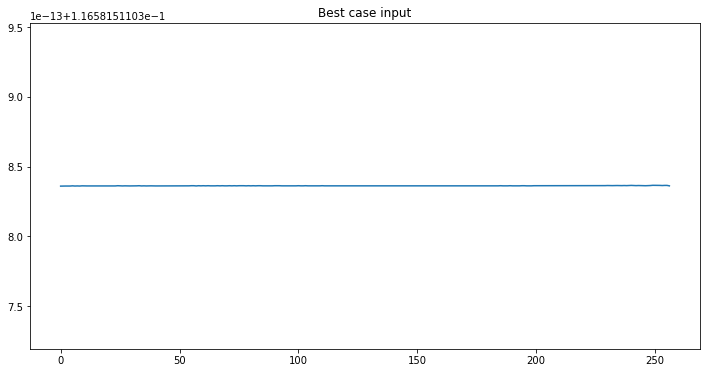

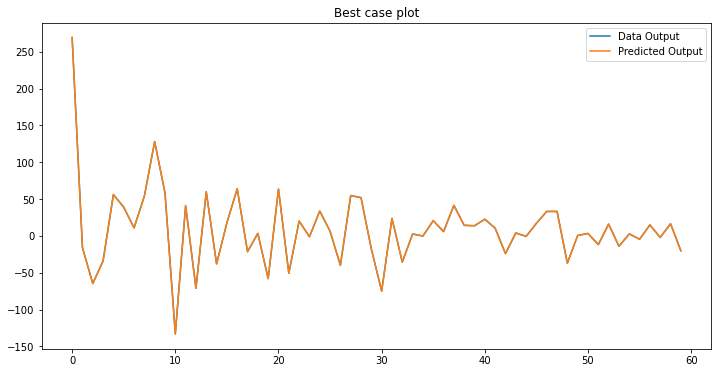

Worst model has a error of  0.000898992903182189


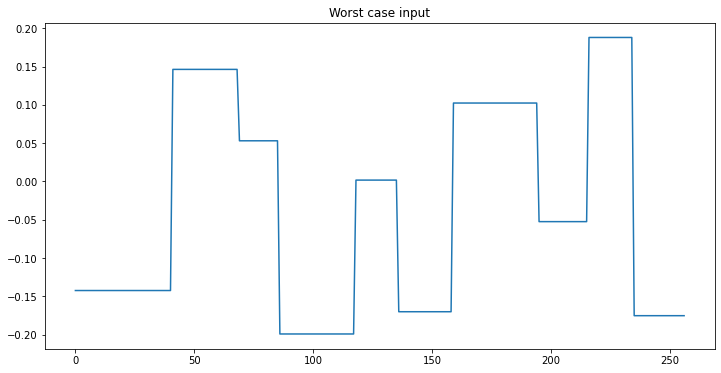

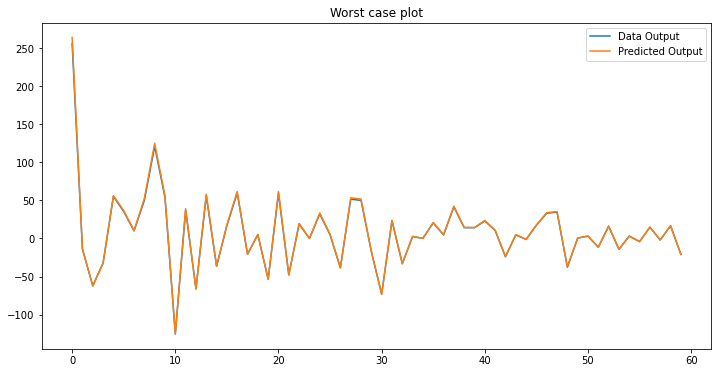

In [14]:
# Print Accuracy for the Testing data using the current model (Not the best one)
test(model, geoid_test_loader, device)

Total loss for the model is 0.0006543282672528423
Accuracy for the model is 100

Best model has a error of  8.84977352528783e-07


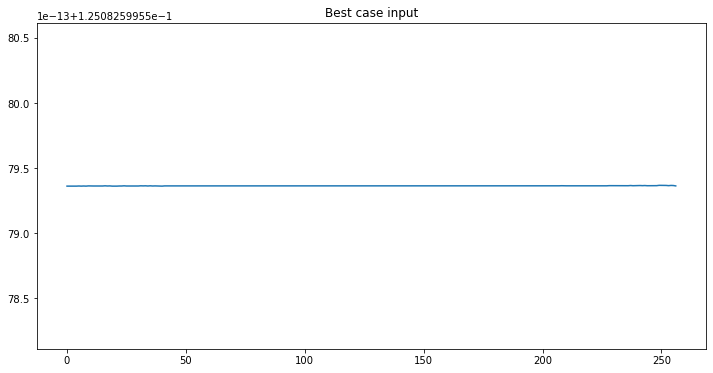

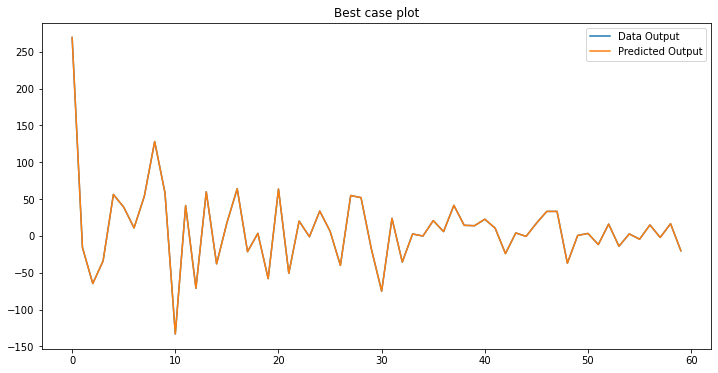

Worst model has a error of  0.00011690946115542358


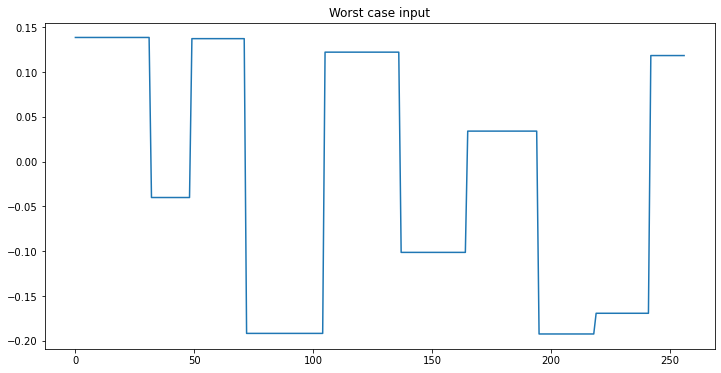

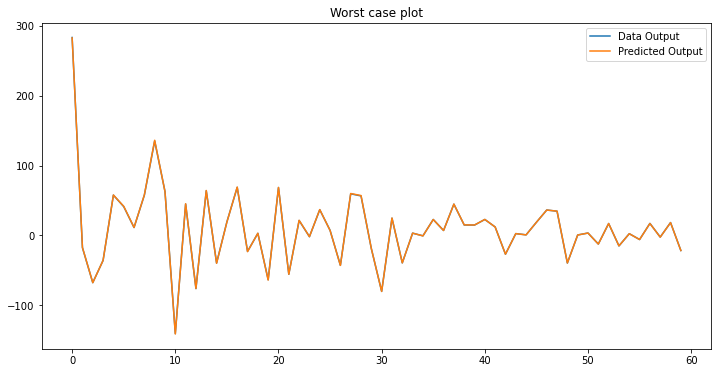

In [15]:
# Print Accuracy for the training data using the best one
model.load_state_dict(torch.load('geoid_model_best.pth'))
test(model, geoid_train_loader, device)

Total loss for the model is 0.0007579730063794945
Accuracy for the model is 100

Best model has a error of  8.87803404791261e-07


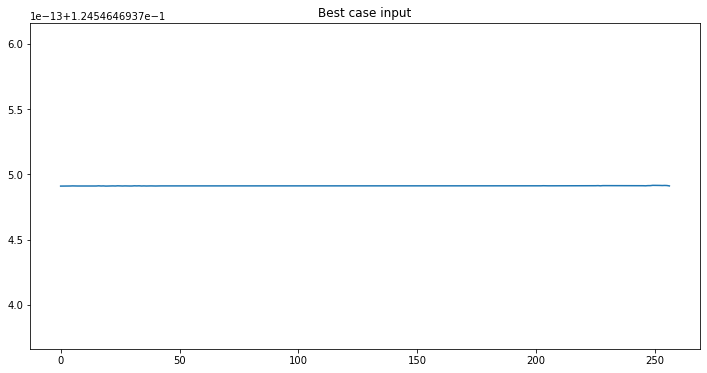

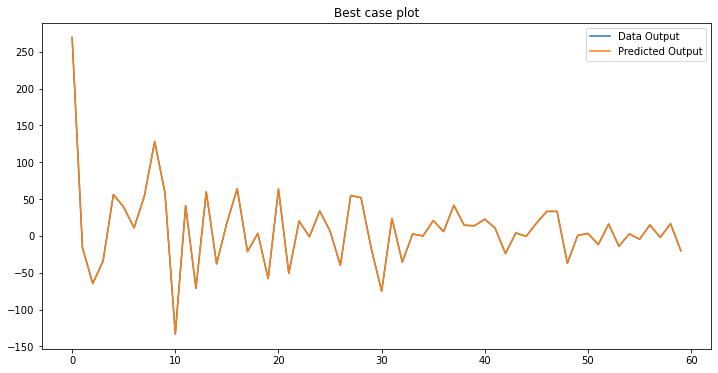

Worst model has a error of  0.0010622848657085785


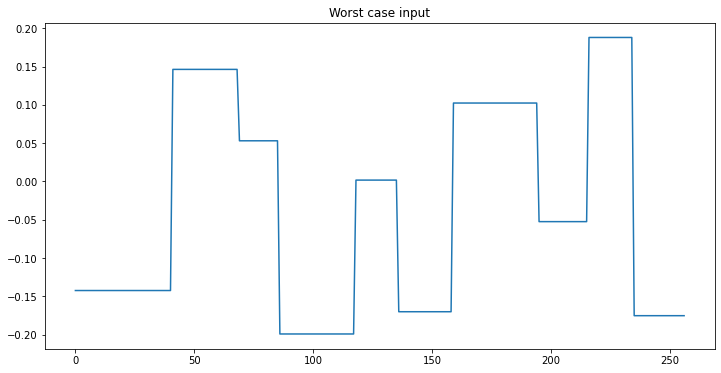

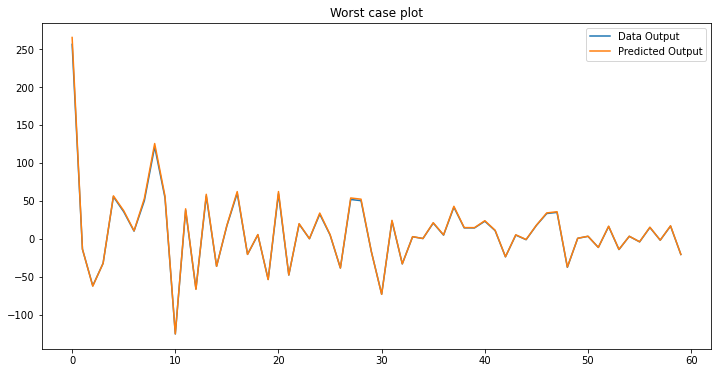

In [16]:
# Print Accuracy for the Testing data using the Best model
test(model, geoid_test_loader, device)

Loss between predicted output and actual output (Both Normalised) 2.6907493205957213e-06


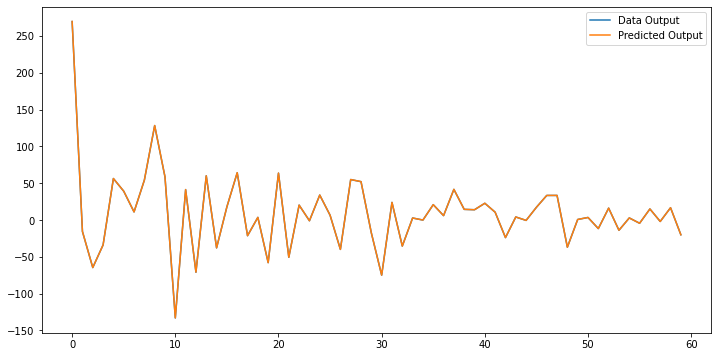

Loss between predicted output and actual output (Both Normalised) 6.641527125163877e-05


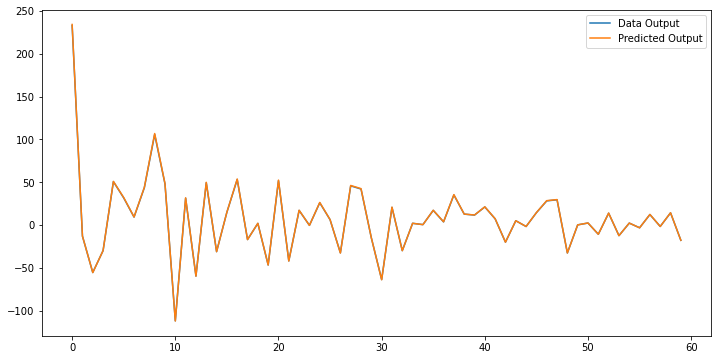

Loss between predicted output and actual output (Both Normalised) 0.0001412086816275507


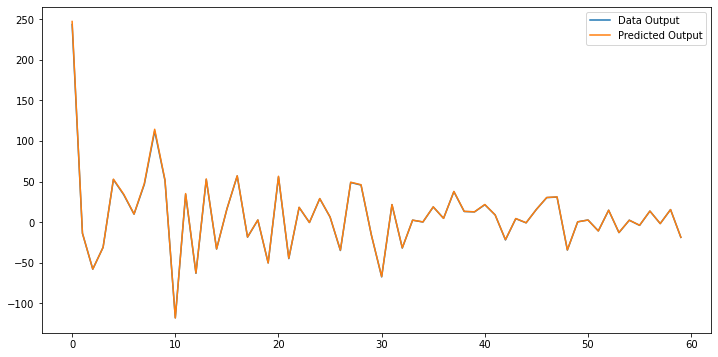

Loss between predicted output and actual output (Both Normalised) 0.00046426024505265723


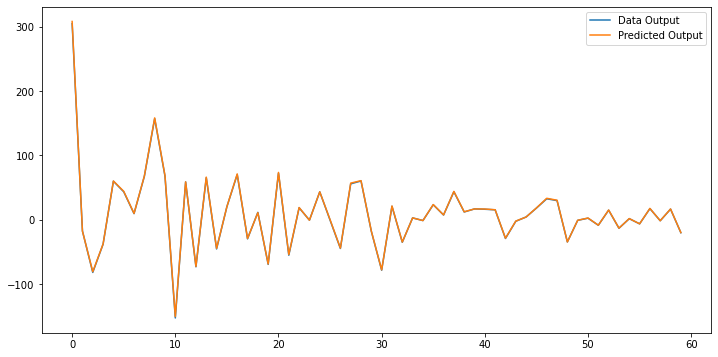

Loss between predicted output and actual output (Both Normalised) 1.4347919182547677e-06


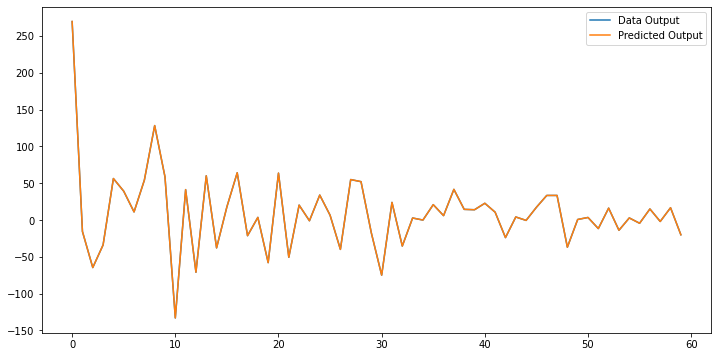

Loss between predicted output and actual output (Both Normalised) 1.2653048244542243e-06


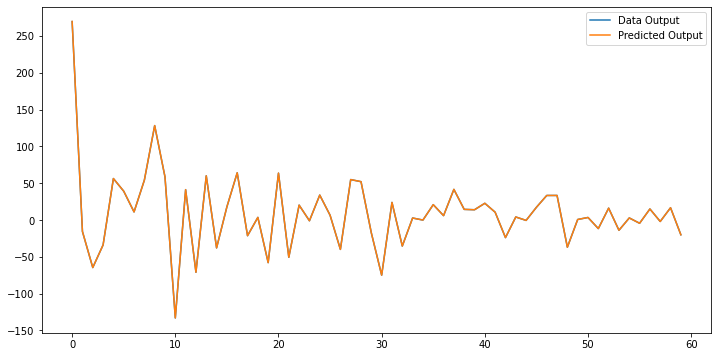

Loss between predicted output and actual output (Both Normalised) 4.312385644542082e-05


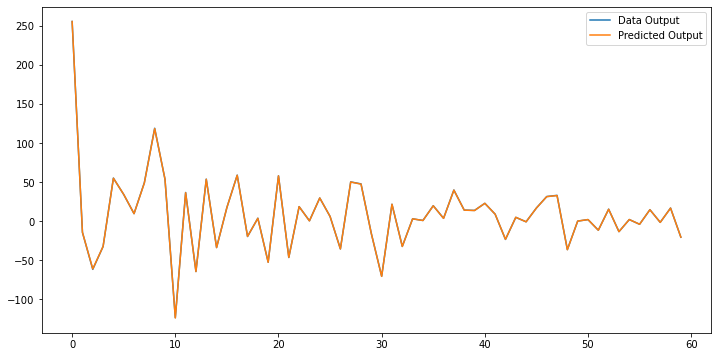

Loss between predicted output and actual output (Both Normalised) 1.384316193717313e-06


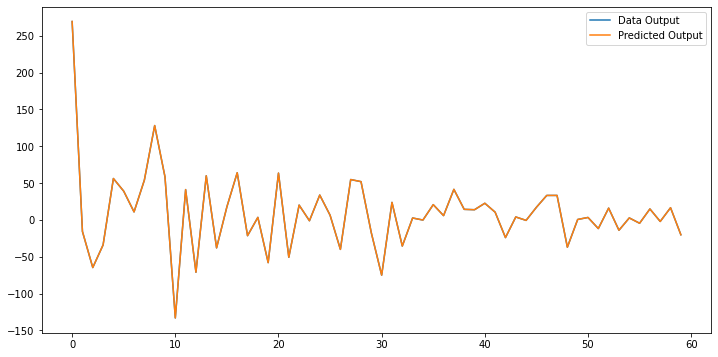

Loss between predicted output and actual output (Both Normalised) 3.516032586469026e-05


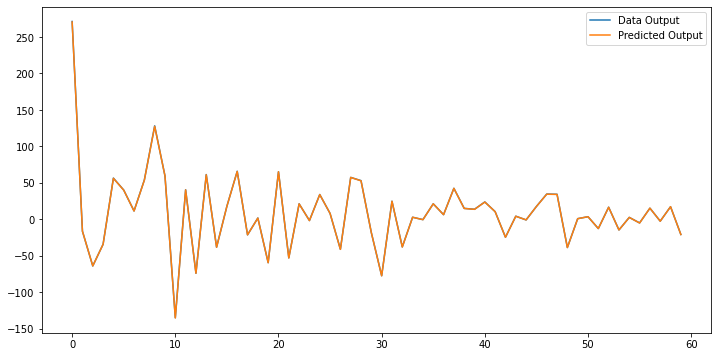

Loss between predicted output and actual output (Both Normalised) 1.8210024118099416e-06


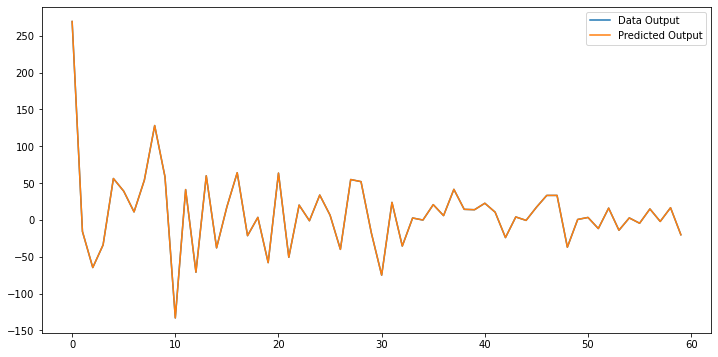

Loss between predicted output and actual output (Both Normalised) 1.940905705681514e-06


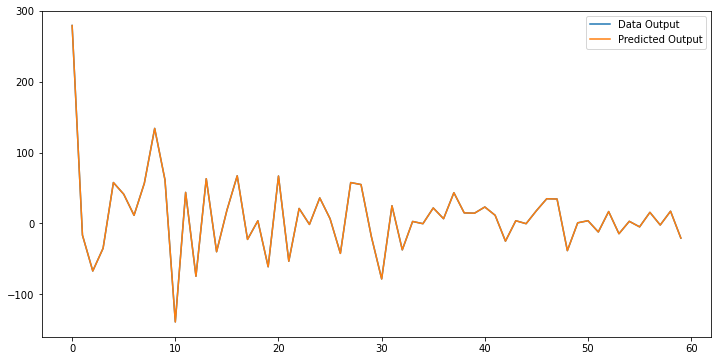

Loss between predicted output and actual output (Both Normalised) 1.773885166988744e-05


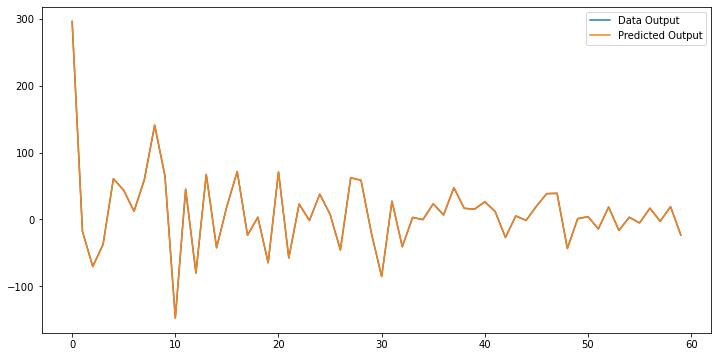

Loss between predicted output and actual output (Both Normalised) 1.3218056674694726e-06


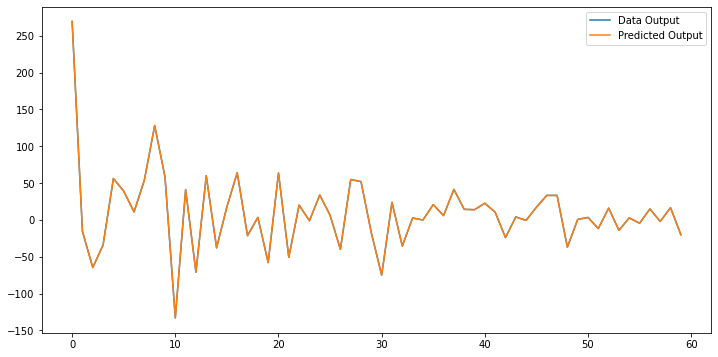

Loss between predicted output and actual output (Both Normalised) 1.5430432175361927e-05


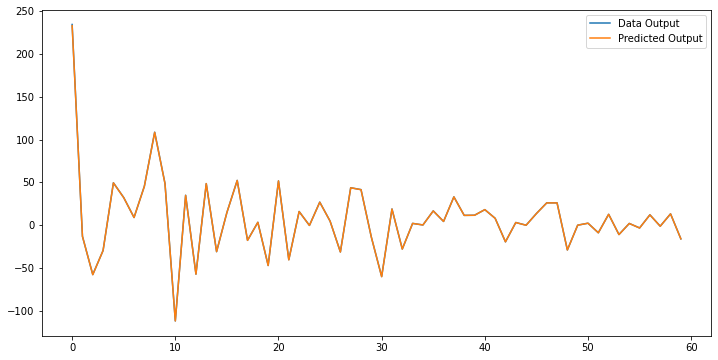

Loss between predicted output and actual output (Both Normalised) 1.5244957117884208e-06


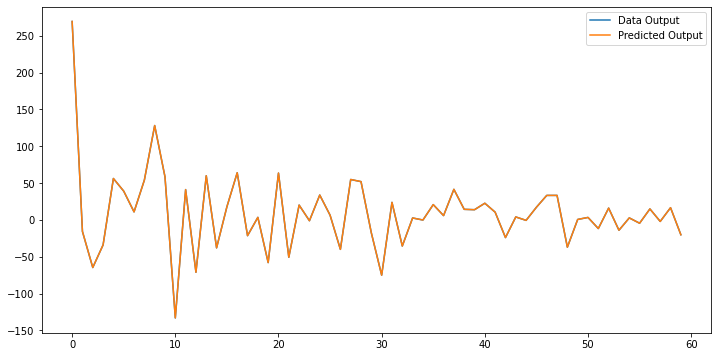

Loss between predicted output and actual output (Both Normalised) 1.595000203413814e-06


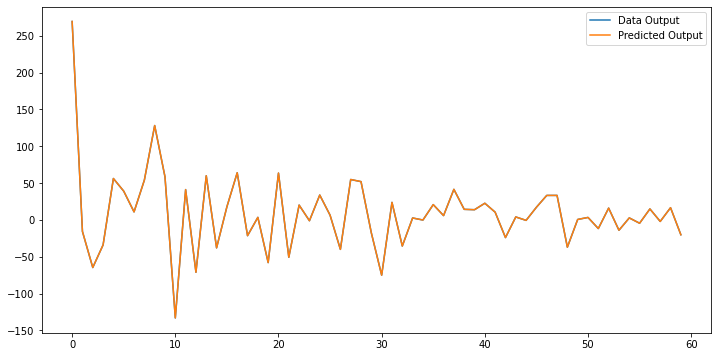

In [17]:
# Testing for a complete batch in the test dataset using the best model

model.load_state_dict(torch.load('geoid_model_best.pth'))
testing_criterion = nn.MSELoss()

test_input, test_output = next(iter(geoid_test_loader))
for i in range(batch_size):    
    test_index = i
    test_input_batch_sample = test_input[test_index]
    test_output_batch_sample = test_output[test_index]
    predicted_output = model(test_input_batch_sample)
    
    loss = testing_criterion(test_output_batch_sample, predicted_output)
    print("Loss between predicted output and actual output (Both Normalised)",loss.item())
    
    #print(scaler.inverse_transform([predicted_output.detach().numpy()])[0])
    
    plt.figure(figsize=(12, 6))
    
    plt.plot(scaler.inverse_transform([test_output_batch_sample.detach().numpy()])[0], label='Data Output')
    plt.plot(scaler.inverse_transform([predicted_output.detach().numpy()])[0], label='Predicted Output')
    plt.legend()

    plt.show()

In [18]:
'''
for name, param in model.named_parameters():
    if param.requires_grad:
        print (name, param.data)
'''

'\nfor name, param in model.named_parameters():\n    if param.requires_grad:\n        print (name, param.data)\n'